In [1]:
from keras.preprocessing import image
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


## Load training, validation, and testing datasets

In [2]:
# intitalize image data generator
datagen = image.ImageDataGenerator()

In [118]:
# load training dataset as generator
train_it = datagen.flow_from_directory('train/', class_mode='categorical', batch_size=64,target_size=(224, 224))

Found 2030 images belonging to 2 classes.


In [119]:
train_it.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [4]:
# load validation dataset as generator
val_it = datagen.flow_from_directory('val/', class_mode='categorical', batch_size=64, target_size=(224, 224))

Found 698 images belonging to 2 classes.


In [5]:
# load testing dataset as generator
test_it = datagen.flow_from_directory('test/', class_mode='categorical', batch_size=64, target_size=(224, 224))

Found 624 images belonging to 2 classes.


## Define input layer shape

In [6]:
image_input = Input(shape=(224, 224, 3))

## Define global epochs

In [7]:
custom_epochs = 5

## Transfer learning using VGG16

In [8]:
from keras.applications.vgg16 import VGG16

In [9]:
model = VGG16()

In [10]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
model = VGG16(input_tensor = image_input, include_top=True)

In [12]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Replace the output layer with my custom output layer

In [13]:
last_layer = model.get_layer('fc2').output

In [14]:
out = Dense(2, activation='softmax', name='output')(last_layer)

In [15]:
custom_vgg16 = Model(image_input, out)

In [16]:
custom_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Freeze all layers, expect the output layer
### Only train the output layer to classify normal or pneumonia

In [17]:
#freeze all layers, expect the last layer
for layer in custom_vgg16.layers[:-1]:
    layer.trainable = False

In [18]:
custom_vgg16.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

In [19]:
custom_vgg16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Create callback checkpoint so we can save the best model

In [20]:
checkpoint = ModelCheckpoint('custom_vgg16_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [21]:
h = custom_vgg16.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 444s 28s/step - loss: 0.7689 - accuracy: 0.7900 - precision_1: 0.7900 - recall_1: 0.7900 - val_loss: 1.0106 - val_accuracy: 0.7812 - val_precision_1: 0.7812 - val_recall_1: 0.7812

Epoch 00001: val_loss improved from inf to 1.01056, saving model to custom_vgg16_best_weights.h5
Epoch 2/5
16/16 [==============================] - 402s 25s/step - loss: 0.3341 - accuracy: 0.8767 - precision_1: 0.8767 - recall_1: 0.8767 - val_loss: 0.2052 - val_accuracy: 0.8854 - val_precision_1: 0.8854 - val_recall_1: 0.8854

Epoch 00002: val_loss improved from 1.01056 to 0.20520, saving model to custom_vgg16_best_weights.h5
Epoch 3/5
16/16 [==============================] - 403s 25s/step - loss: 0.2784 - accuracy: 0.9036 - precision_1: 0.9036 - recall_1: 0.9036 - val_loss: 0.1514 - val_accuracy: 0.9328 - val_precision_1: 0.9328 - val_recall_1: 0.9328

Epoch 00003: val_loss improved from 0.20520 to 0.15141, saving model to custom_vgg16_best_weights.h5
Epoch

### Plot metrics 

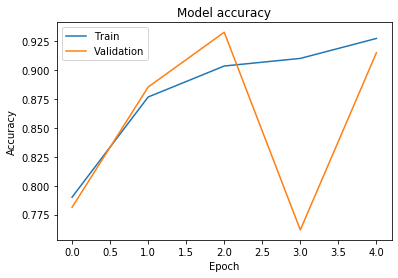

In [22]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

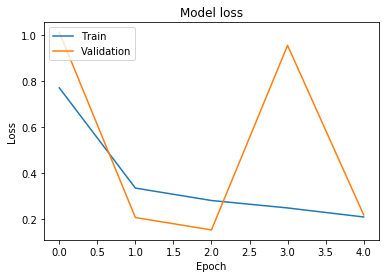

In [23]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

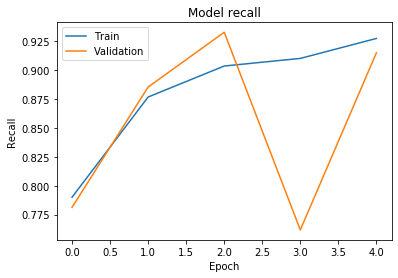

In [25]:
# Plot training & validation recall values
plt.plot(h.history['recall_1'])
plt.plot(h.history['val_recall_1'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

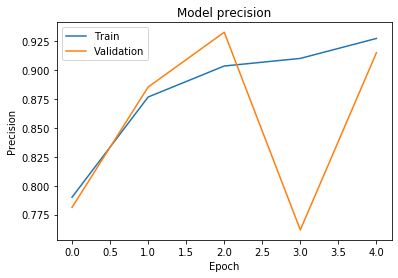

In [26]:
# Plot training & validation precision values
plt.plot(h.history['precision_1'])
plt.plot(h.history['val_precision_1'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate model against the test dataset

In [27]:
# evaluate model
# load the best weights 
custom_vgg16.load_weights('custom_vgg16_best_weights.h5')
metrics_result = custom_vgg16.evaluate_generator(test_it, steps=24)

### Evaluation results

In [28]:
print(f'{custom_vgg16.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_vgg16.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_vgg16.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_vgg16.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 0.40950506925582886
accuracy: 87.57%
precision_1: 87.57%
recall_1: 87.57%


## Transfer Leaening using ResNet50

In [29]:
from keras.applications.resnet import ResNet50

In [30]:
model = ResNet50()

In [31]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [32]:
model = ResNet50(input_tensor = image_input, include_top=True)

In [33]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Replace the output layer with my custom output layer

In [34]:
last_layer = model.get_layer('avg_pool').output

In [35]:
out = Dense(2, activation='softmax', name='output')(last_layer)

In [36]:
custom_resnet50 = Model(image_input, out)

In [37]:
custom_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Freeze all layers, expect the output layer
### Only train the output layer to classify normal or pneumonia

In [38]:
#freeze all layers, expect the last layer
for layer in custom_resnet50.layers[:-1]:
    layer.trainable = False

In [39]:
custom_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [40]:
custom_resnet50.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

### Create callback checkpoint so we can save the best model

In [41]:
checkpoint = ModelCheckpoint('custom_resnet50_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [42]:
h = custom_resnet50.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 223s 14s/step - loss: 0.5093 - accuracy: 0.7637 - precision_2: 0.7637 - recall_2: 0.7637 - val_loss: 0.6828 - val_accuracy: 0.6152 - val_precision_2: 0.6152 - val_recall_2: 0.6152

Epoch 00001: val_loss improved from inf to 0.68276, saving model to custom_resnet50_best_weights.h5
Epoch 2/5
16/16 [==============================] - 202s 13s/step - loss: 0.2633 - accuracy: 0.9105 - precision_2: 0.9105 - recall_2: 0.9105 - val_loss: 0.8763 - val_accuracy: 0.6107 - val_precision_2: 0.6107 - val_recall_2: 0.6107

Epoch 00002: val_loss did not improve from 0.68276
Epoch 3/5
16/16 [==============================] - 207s 13s/step - loss: 0.2198 - accuracy: 0.9175 - precision_2: 0.9175 - recall_2: 0.9175 - val_loss: 0.9502 - val_accuracy: 0.5237 - val_precision_2: 0.5237 - val_recall_2: 0.5237

Epoch 00003: val_loss did not improve from 0.68276
Epoch 4/5
16/16 [==============================] - 207s 13s/step - loss: 0.2048 - accuracy: 0.9141 - p

### Plot metrics 

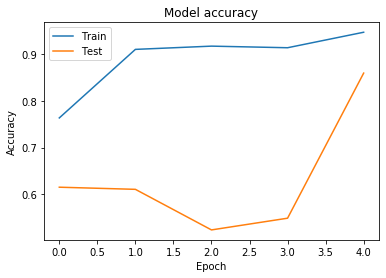

In [43]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

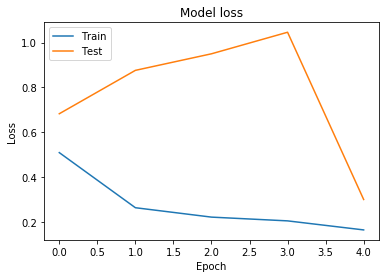

In [44]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

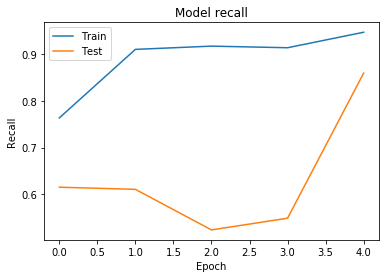

In [47]:
# Plot training & validation recall values
plt.plot(h.history['recall_2'])
plt.plot(h.history['val_recall_2'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

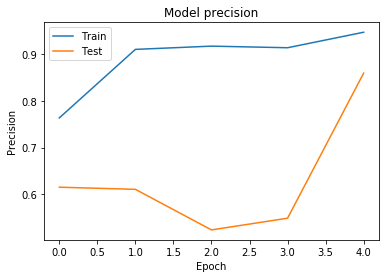

In [48]:
# Plot training & validation precision values
plt.plot(h.history['precision_2'])
plt.plot(h.history['val_precision_2'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Evaluate model against the test dataset

In [49]:
# load the best weights 
custom_resnet50.load_weights('custom_resnet50_best_weights.h5')
metrics_result = custom_resnet50.evaluate_generator(test_it, steps=24)

### Evaluation results

In [50]:
print(f'{custom_resnet50.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_resnet50.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_resnet50.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_resnet50.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 0.5280035734176636
accuracy: 76.20%
precision_2: 76.20%
recall_2: 76.20%


## Transfer Leaening using InceptionV3

In [51]:
from keras.applications.inception_v3 import InceptionV3

In [52]:
model = InceptionV3()

In [53]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [54]:
model = InceptionV3(input_tensor = image_input, include_top=True)

In [55]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
_______________________________________________________________________________________

### Replace the output layer with my custom output layer

In [56]:
last_layer = model.get_layer('avg_pool').output

In [57]:
out = Dense(2, activation='softmax', name='output')(last_layer)

In [58]:
custom_inceptionv3 = Model(image_input, out)

In [59]:
custom_inceptionv3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

### freeze all layers, expect the last layer
### Only train the classsification layer

In [60]:
for layer in custom_inceptionv3.layers[:-1]:
    layer.trainable = False

In [61]:
custom_inceptionv3.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

In [62]:
custom_inceptionv3.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

### Create callback checkpoint so we can save the best model

In [63]:
checkpoint = ModelCheckpoint('custom_inceptionv3_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [64]:
h = custom_inceptionv3.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 148s 9s/step - loss: 0.7597 - accuracy: 0.5576 - precision_3: 0.5576 - recall_3: 0.5576 - val_loss: 29.6287 - val_accuracy: 0.4824 - val_precision_3: 0.4824 - val_recall_3: 0.4824

Epoch 00001: val_loss improved from inf to 29.62868, saving model to custom_inceptionv3_best_weights.h5
Epoch 2/5
16/16 [==============================] - 119s 7s/step - loss: 0.5723 - accuracy: 0.7028 - precision_3: 0.7028 - recall_3: 0.7028 - val_loss: 28.3075 - val_accuracy: 0.5257 - val_precision_3: 0.5257 - val_recall_3: 0.5257

Epoch 00002: val_loss improved from 29.62868 to 28.30752, saving model to custom_inceptionv3_best_weights.h5
Epoch 3/5
16/16 [==============================] - 117s 7s/step - loss: 0.4606 - accuracy: 0.8161 - precision_3: 0.8161 - recall_3: 0.8161 - val_loss: 27.5886 - val_accuracy: 0.4862 - val_precision_3: 0.4862 - val_recall_3: 0.4862

Epoch 00003: val_loss improved from 28.30752 to 27.58858, saving model to custom_inceptionv

### Plot metrics 

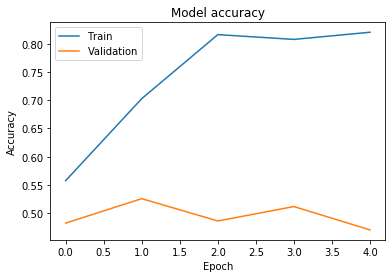

In [65]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

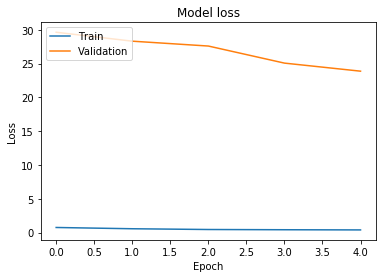

In [66]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

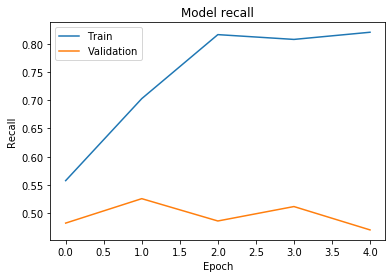

In [68]:
# Plot training & validation recall values
plt.plot(h.history['recall_3'])
plt.plot(h.history['val_recall_3'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

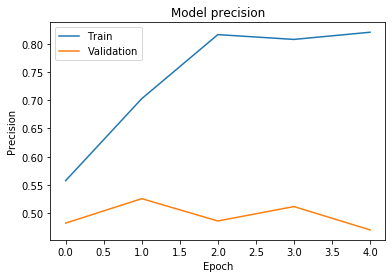

In [69]:
# Plot training & validation precision values
plt.plot(h.history['precision_3'])
plt.plot(h.history['val_precision_3'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate model against the test dataset

In [70]:
# load the best weights 
custom_inceptionv3.load_weights('custom_inceptionv3_best_weights.h5')
metrics_result = custom_inceptionv3.evaluate_generator(test_it, steps=24)

### Evaluation results

In [71]:
print(f'{custom_inceptionv3.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_inceptionv3.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_inceptionv3.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_inceptionv3.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 14.139808654785156
accuracy: 62.70%
precision_3: 62.70%
recall_3: 62.70%


## Transfer Leaening using MobileNet

In [72]:
from keras.applications.mobilenet import MobileNet

In [73]:
model = MobileNet()

In [74]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [75]:
model = MobileNet(input_tensor = image_input, include_top=True)

In [76]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

### Replace the output layer with my custom output layer

In [77]:
last_layer = model.get_layer('reshape_2').output

In [78]:
out = Dense(2, activation='softmax', name='output')(last_layer)

In [79]:
custom_mobilenet = Model(image_input, out)

In [80]:
custom_mobilenet.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

### freeze all layers, expect the last layer
### Only train the classsification layer

In [81]:
for layer in custom_mobilenet.layers[:-1]:
    layer.trainable = False

In [82]:
custom_mobilenet.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [83]:
custom_mobilenet.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

### Create callback checkpoint so we can save the best model

In [84]:
checkpoint = ModelCheckpoint('custom_mobilenet_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [85]:
h = custom_mobilenet.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 114s 7s/step - loss: 0.4747 - accuracy: 0.8516 - precision_4: 0.8516 - recall_4: 0.8516 - val_loss: 1.1323 - val_accuracy: 0.5469 - val_precision_4: 0.5469 - val_recall_4: 0.5469

Epoch 00001: val_loss improved from inf to 1.13225, saving model to custom_mobilenet_best_weights.h5
Epoch 2/5
16/16 [==============================] - 78s 5s/step - loss: 0.2815 - accuracy: 0.9016 - precision_4: 0.9016 - recall_4: 0.9016 - val_loss: 2.3173 - val_accuracy: 0.5059 - val_precision_4: 0.5059 - val_recall_4: 0.5059

Epoch 00002: val_loss did not improve from 1.13225
Epoch 3/5
16/16 [==============================] - 79s 5s/step - loss: 0.1984 - accuracy: 0.9307 - precision_4: 0.9307 - recall_4: 0.9307 - val_loss: 0.9109 - val_accuracy: 0.6364 - val_precision_4: 0.6364 - val_recall_4: 0.6364

Epoch 00003: val_loss improved from 1.13225 to 0.91095, saving model to custom_mobilenet_best_weights.h5
Epoch 4/5
16/16 [==============================] - 7

### Plot metrics 

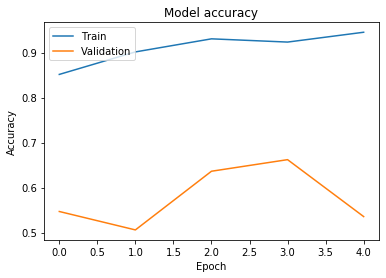

In [86]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

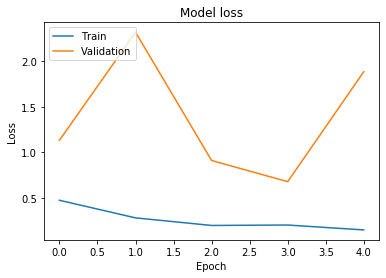

In [87]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

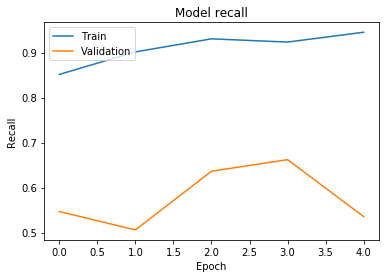

In [89]:
# Plot training & validation recall values
plt.plot(h.history['recall_4'])
plt.plot(h.history['val_recall_4'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

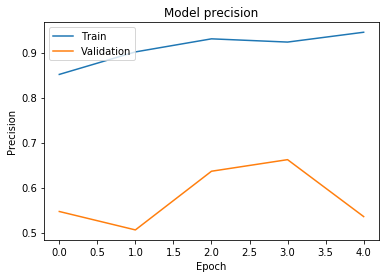

In [90]:
# Plot training & validation precision values
plt.plot(h.history['precision_4'])
plt.plot(h.history['val_precision_4'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate model against test dataset

In [91]:
# load the best weights 
custom_mobilenet.load_weights('custom_mobilenet_best_weights.h5')
metrics_result = custom_mobilenet.evaluate_generator(test_it, steps=24)

### Evaluation results

In [92]:
print(f'{custom_vgg16.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_vgg16.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_vgg16.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_vgg16.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 1.5387237071990967
accuracy: 64.16%
precision_1: 64.16%
recall_1: 64.16%


## Since VGG16 yeild the best result 
## Try VGG19 to see if it can do better

In [93]:
from keras.applications.vgg19 import VGG19

In [94]:
model = VGG19()

In [95]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [96]:
model = VGG19(input_tensor = image_input, include_top=True)

In [97]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Replace the output layer with my custom output layer

In [98]:
last_layer = model.get_layer('fc2').output

In [99]:
out = Dense(2, activation='softmax', name='output')(last_layer)

In [100]:
custom_vgg19 = Model(image_input, out)

In [101]:
custom_vgg19.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### freeze all layers, expect the last layer
### Only train the classsification layer

In [102]:
for layer in custom_vgg19.layers[:-1]:
    layer.trainable = False

In [103]:
custom_vgg19.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [104]:
custom_vgg19.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy', Precision(), Recall()]
)

### Create callback checkpoint so we can save the best model

In [105]:
checkpoint = ModelCheckpoint('custom_vgg19_best_weights.h5', verbose=1, save_best_only=True)

### Train the model

In [106]:
h = custom_vgg19.fit_generator(
    train_it, 
    steps_per_epoch=16, 
    validation_data=val_it, 
    validation_steps=8,
    callbacks=[checkpoint],
    epochs=custom_epochs
)

Epoch 1/5
16/16 [==============================] - 518s 32s/step - loss: 0.9025 - accuracy: 0.7549 - precision_5: 0.7549 - recall_5: 0.7549 - val_loss: 0.1469 - val_accuracy: 0.9199 - val_precision_5: 0.9199 - val_recall_5: 0.9199

Epoch 00001: val_loss improved from inf to 0.14691, saving model to custom_vgg19_best_weights.h5
Epoch 2/5
16/16 [==============================] - 488s 31s/step - loss: 0.3415 - accuracy: 0.8738 - precision_5: 0.8738 - recall_5: 0.8738 - val_loss: 0.2534 - val_accuracy: 0.8775 - val_precision_5: 0.8775 - val_recall_5: 0.8775

Epoch 00002: val_loss did not improve from 0.14691
Epoch 3/5
16/16 [==============================] - 501s 31s/step - loss: 0.2482 - accuracy: 0.9141 - precision_5: 0.9141 - recall_5: 0.9141 - val_loss: 0.5566 - val_accuracy: 0.7747 - val_precision_5: 0.7747 - val_recall_5: 0.7747

Epoch 00003: val_loss did not improve from 0.14691
Epoch 4/5
16/16 [==============================] - 478s 30s/step - loss: 0.2947 - accuracy: 0.8936 - prec

### Plot metrics 

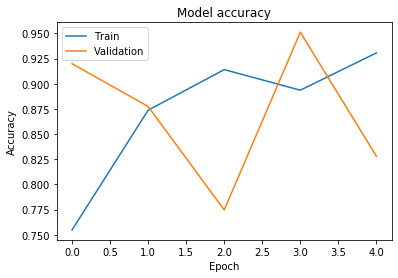

In [107]:
# Plot training & validation accuracy values
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

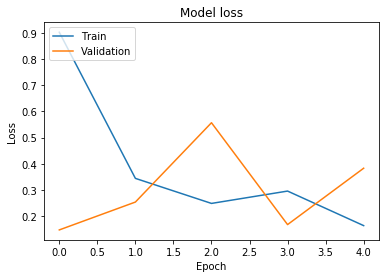

In [108]:
# Plot training & validation loss values
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

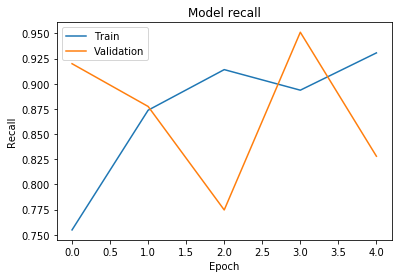

In [110]:
# Plot training & validation recall values
plt.plot(h.history['recall_5'])
plt.plot(h.history['val_recall_5'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

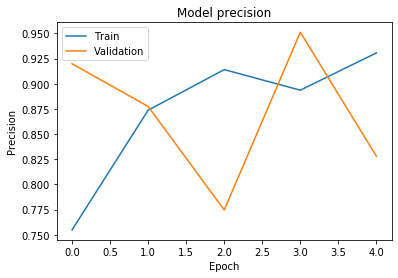

In [111]:
# Plot training & validation precision values
plt.plot(h.history['precision_5'])
plt.plot(h.history['val_precision_5'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Evaluate model against test dataset

In [112]:
# load the best weights 
custom_vgg19.load_weights('custom_vgg19_best_weights.h5')
metrics_result = custom_vgg19.evaluate_generator(test_it, steps=24)

### Evaluation results

In [113]:
print(f'{custom_vgg19.metrics_names[0]}: {metrics_result[0]}' )
print(f'{custom_vgg19.metrics_names[1]}: {"{:.2%}".format(metrics_result[1])}' )
print(f'{custom_vgg19.metrics_names[2]}: {"{:.2%}".format(metrics_result[2])}' )
print(f'{custom_vgg19.metrics_names[3]}: {"{:.2%}".format(metrics_result[3])}' )

loss: 0.4045296907424927
accuracy: 83.84%
precision_5: 83.84%
recall_5: 83.84%


## VGG16 has the best performance 

### Create VGG16 application to predict normal or pneumonia

In [114]:
#create a make prediction function
custom_vgg16.load_weights('custom_vgg16_best_weights.h5')
def make_prediction(image_path):
    try:
        categories = ['Normal', 'Pneumonia']
        img = image.load_img(image_path, target_size=(224, 224))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        pred = custom_vgg16.predict(img_tensor)
        print(pred)
        print('********Diagnostic Result***********')
        print('>>>> ',categories[np.argmax(pred[0])], "{:.2%}".format(pred[0][np.argmax(pred[0])]))
        print('*************************************')
        img_tensor/=255
        plt.imshow(img_tensor[0])
    except:
        print('Invalid image file!')
        return

### Randomly choose 3 files from test dataset to check result

[[1.4752333e-06 9.9999857e-01]]
********Diagnostic Result***********
>>>>  Pneumonia 100.00%
*************************************


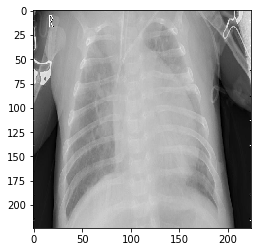

In [115]:
make_prediction('test/PNEUMONIA/person1_virus_7.jpeg')

[[0.09626378 0.90373623]]
********Diagnostic Result***********
>>>>  Pneumonia 90.37%
*************************************


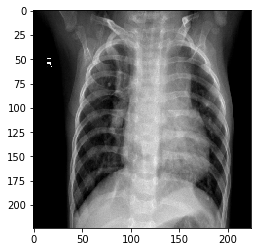

In [116]:
make_prediction('test/PNEUMONIA/person103_bacteria_490.jpeg')

[[0.9974738 0.0025262]]
********Diagnostic Result***********
>>>>  Normal 99.75%
*************************************


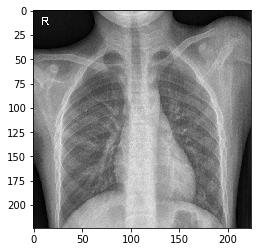

In [117]:
make_prediction('test/NORMAL/IM-0011-0001.jpeg')